# ULMFiT Sentiment Analysis - NLTK

#### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, CuDNNGRU, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras.initializers import Constant

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, classification_report


In [2]:
pd.set_option('display.max_colwidth', 0)         
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
#**Adding module’s sub-directory to Pythons path**
import os
import sys
sys.path.insert(0, os.path.abspath('../helpers'))
import data

#### Data Preview

In [4]:
df_data = pd.read_csv("..\data\Tweets.csv")
df_data.sample()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
2920,568831574474661888,negative,1.0,Damaged Luggage,0.6406,United,NaN,mrphoto,NaN,0,@united airlines abuse your expensive video equipment and overcharge you for the privilege http://t.co/SdyLuKR7pt via @robthecameraman,NaN,2015-02-20 09:56:30 -0800,"Chew Valley, North Somerset UK",London


#### Data Cleaning

In [5]:
def tweet_to_words(tweet):
    """
    
    """
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
    tweet = re.sub("[^a-zA-Z]", " ", tweet) # Remove special characters
    tweet = tweet.lower() # convert text to lower-case
    words = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello) 
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    
    return( " ".join(meaningful_words))

df_tweets = df_data.filter(items=['airline_sentiment', 'text'])
df_tweets['text'] = df_tweets['text'].apply(lambda x: tweet_to_words(x))
df_tweets

,airline_sentiment,text
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests faces amp little recourse
4,negative,virginamerica really big bad thing
...,...,...
14635,positive,americanair thank got different flight chicago
14636,negative,americanair leaving minutes late flight warnings communication minutes late flight called shitty customer svc
14637,neutral,americanair please bring american airlines blackberry
14638,negative,americanair money change flight answer phones suggestions make commitment


#### Data Preprocessing

In [6]:
le_model = LabelEncoder()
df_tweets['airline_sentiment'] = le_model.fit_transform(df_tweets['airline_sentiment'])
df_tweets.to_csv('..\data\Just_Tweets.csv', index=False)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
airline_sentiment    14640 non-null int32
text                 14640 non-null object
dtypes: int32(1), object(1)
memory usage: 171.7+ KB


#### Data Test and Train Splits

In [7]:
train_data, test_data = data.create_splits(df_tweets, 'airline_sentiment')

print('Ratios in the order - positive : neutral : negative!')
pv_num = len(train_data[train_data['airline_sentiment']==2])
nn_num = len(train_data[train_data['airline_sentiment']==1])  
nv_num = len(train_data[train_data['airline_sentiment']==0]) 
print('Training ratio: {}:{}:{}'.format(pv_num/pv_num, nn_num/pv_num, nv_num/pv_num))

pv_num = len(test_data[test_data['airline_sentiment']==2])
nn_num = len(test_data[test_data['airline_sentiment']==1])
nv_num = len(test_data[test_data['airline_sentiment']==0])
print('Testing ratio: {}:{}:{}'.format(pv_num/pv_num, nn_num/pv_num, nv_num/pv_num))

Ratios in the order - positive : neutral : negative!
Training ratio: 1.0:1.0:1.0
Testing ratio: 1.0:1.0:3.0


In [8]:
train_clean_tweets=[]
for tweet in train_data['text']:
    train_clean_tweets.append(tweet)
    
test_clean_tweets=[]
for tweet in test_data['text']:
    test_clean_tweets.append(tweet)

In [9]:
vectorizer = CountVectorizer(analyzer="word")
train_features= vectorizer.fit_transform(train_clean_tweets)
test_features= vectorizer.transform(test_clean_tweets)

#### Bernoulli Model (Naive Bayes)

1. __Bernoulli NB__: It should be used for features with binary or boolean values like True/False or 0/1.
2. __Gaussian NB__: It should be used for features in decimal form. GNB assumes features to follow a normal distribution.
3. __MultiNomial NB__: It should be used for the features with discrete values like word count 1,2,3...


#### Bernoulli NB

In [10]:
bnb_model = BernoulliNB()
bnb_model.fit(train_features, train_data['airline_sentiment'])

accuracy_train = accuracy_score(bnb_model.predict(train_features), train_data['airline_sentiment'])
print('Training Acc. : {:.2f}'.format(accuracy_train))

Training Acc. : 0.87


In [11]:
y_pred = bnb_model.predict(test_features)
y_true = test_data['airline_sentiment']
target_names = ['Negative', 'Neutral', 'Positive']

print("F1 score : {:.2f}".format(f1_score(y_true, y_pred, average='weighted')))
print("Precision score: {:.2f}".format(precision_score(y_true, y_pred, average='micro')))
print("Recall score : {:.2f}\n".format(recall_score(y_true, y_pred, average='micro')))

print(classification_report(y_true, y_pred, target_names=target_names))

F1 score : 0.74
Precision score: 0.73
Recall score : 0.73

              precision    recall  f1-score   support

    Negative       0.91      0.73      0.81      1416
     Neutral       0.52      0.68      0.59       472
    Positive       0.62      0.81      0.70       472

    accuracy                           0.73      2360
   macro avg       0.68      0.74      0.70      2360
weighted avg       0.78      0.73      0.74      2360



Text(0.5, 15.0, 'Predicted label')

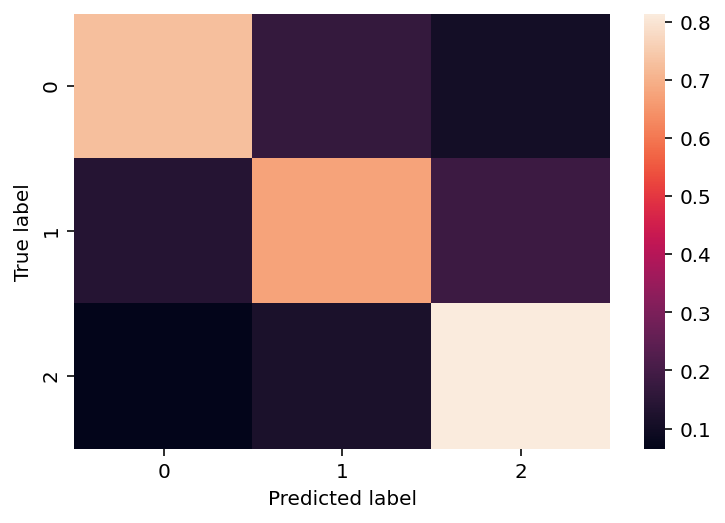

In [12]:
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Gaussian NB

In [13]:
gnb_model = GaussianNB()
gnb_model.fit(np.array(train_features.todense()), train_data['airline_sentiment'].array)

accuracy_train = accuracy_score(gnb_model.predict(np.array(train_features.todense())), train_data['airline_sentiment'].array)
print('Training Acc. : {:.2f}'.format(accuracy_train))

Training Acc. : 0.80


In [14]:
y_pred = gnb_model.predict((np.array(test_features.todense())))
y_true = test_data['airline_sentiment']
target_names = ['Negative', 'Neutral', 'Positive']

print("F1 score : {:.2f}".format(f1_score(y_true, y_pred, average='weighted')))
print("Precision score: {:.2f}".format(precision_score(y_true, y_pred, average='micro')))
print("Recall score : {:.2f}\n".format(recall_score(y_true, y_pred, average='micro')))

print(classification_report(y_true, y_pred, target_names=target_names))

F1 score : 0.50
Precision score: 0.48
Recall score : 0.48

              precision    recall  f1-score   support

    Negative       0.87      0.42      0.57      1416
     Neutral       0.34      0.35      0.34       472
    Positive       0.32      0.80      0.45       472

    accuracy                           0.48      2360
   macro avg       0.51      0.52      0.45      2360
weighted avg       0.66      0.48      0.50      2360



Text(0.5, 15.0, 'Predicted label')

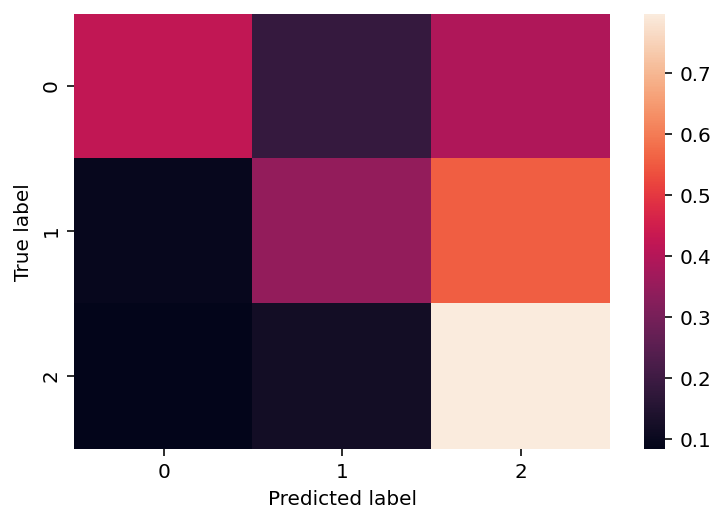

In [15]:
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### MultiNomial NB

In [16]:
mnb_model = MultinomialNB()
mnb_model.fit(train_features, train_data['airline_sentiment'])

accuracy_train = accuracy_score(mnb_model.predict(train_features), train_data['airline_sentiment'])
print('Training Acc. : {:.2f}'.format(accuracy_train))

Training Acc. : 0.86


In [17]:
y_pred = mnb_model.predict(test_features)
y_true = test_data['airline_sentiment']
target_names = ['Negative', 'Neutral', 'Positive']

print("F1 score : {:.2f}".format(f1_score(y_true, y_pred, average='weighted')))
print("Precision score: {:.2f}".format(precision_score(y_true, y_pred, average='micro')))
print("Recall score : {:.2f}\n".format(recall_score(y_true, y_pred, average='micro')))

print(classification_report(y_true, y_pred, target_names=target_names))

F1 score : 0.76
Precision score: 0.76
Recall score : 0.76

              precision    recall  f1-score   support

    Negative       0.88      0.80      0.84      1416
     Neutral       0.56      0.58      0.57       472
    Positive       0.66      0.81      0.73       472

    accuracy                           0.76      2360
   macro avg       0.70      0.73      0.71      2360
weighted avg       0.77      0.76      0.76      2360



Text(0.5, 15.0, 'Predicted label')

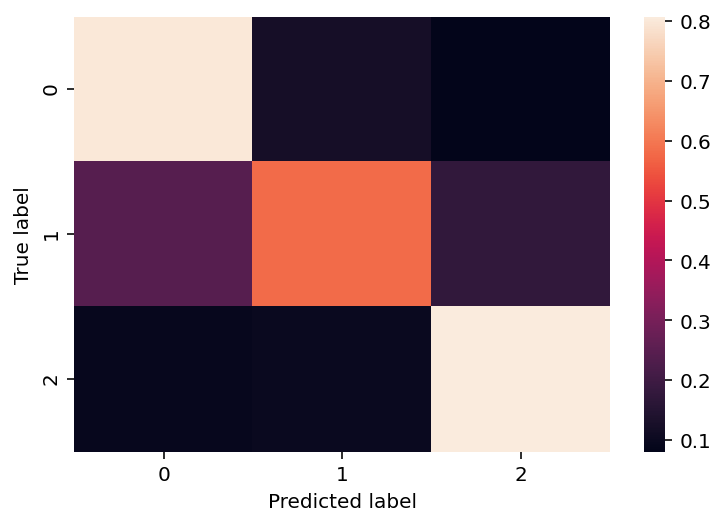

In [18]:
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized)
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Logistic Regression Model

#### Using empty word embedding and LSTM